# Import Library

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Generate Data

In [6]:
IMAGE_SHAPE = (200, 200)
TRAINING_DATA_DIR = 'Covid19-dataset/train'
VALID_DATA_DIR = 'Covid19-dataset/test'

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)
valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Build Model

In [8]:
def build_model(num_classes):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', 
                           input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model
model = build_model(num_classes=3)

# Compile Model

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0

# Train Model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    mode='max'
    )

In [12]:
EPOCHS = 50
BATCH_SIZE = 32
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps= valid_generator.samples // BATCH_SIZE,
                    verbose=1,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
7/7 [==============================] - 8s 1s/step - loss: 0.8164 - accuracy: 0.6530 - val_loss: 0.7419 - val_accuracy: 0.6719
Epoch 2/50
7/7 [==============================] - 9s 1s/step - loss: 0.5783 - accuracy: 0.8447 - val_loss: 0.5588 - val_accuracy: 0.8281
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 0.3906 - accuracy: 0.8721 - val_loss: 0.4305 - val_accuracy: 0.8438
Epoch 4/50
7/7 [==============================] - 8s 1s/step - loss: 0.2616 - accuracy: 0.8995 - val_loss: 0.3432 - val_accuracy: 0.8125
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 0.1475 - accuracy: 0.9589 - val_loss: 0.2617 - val_accuracy: 0.8906
Epoch 6/50
7/7 [==============================] - 9s 1s/step - loss: 0.1402 - accuracy: 0.9452 - val_loss: 0.3245 - val_accuracy: 0.8281
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 0.1212 - accuracy: 0.9635 - val_loss: 0.2313 - val_accuracy: 0.9219
Epoch 8/50
7/7 [=========================

# Plot History

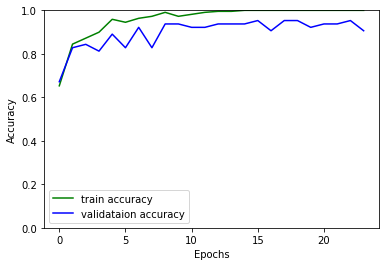

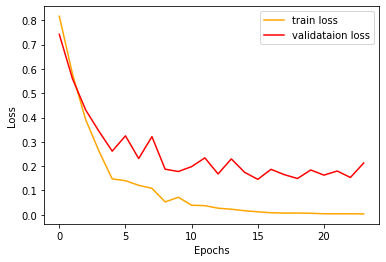

In [13]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim([0,1])
    plt.savefig('img/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('img/loss.png')
    plt.show()
save_plots(train_acc, valid_acc, train_loss, valid_loss)

# Save Model

In [14]:
import datetime
model.save(f'{str(datetime.datetime.now())[:10]}_{round(train_acc[len(train_acc)-1]* 100, 2)}_acc.h5')


# Load & Predict Image

In [15]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

Covid


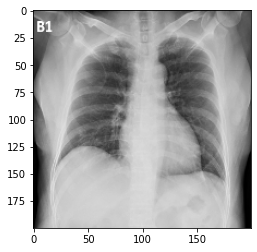

In [17]:
# load model and get upload data to predict
model = tf.keras.models.load_model('2022-06-01_100.0_acc.h5')

# predict image
def predict_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMAGE_SHAPE[1], IMAGE_SHAPE[0]))
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    label = np.argmax(prediction)
    # reverse the dictionary
    label_map = {v: k for k, v in train_generator.class_indices.items()}
    label = label_map[label]
    return label

def preview_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMAGE_SHAPE[1], IMAGE_SHAPE[0]))
    plt.imshow(image)
    plt.show()

print(predict_image('Covid19-dataset/test/Covid/094.png'))
preview_image('Covid19-dataset/test/Covid/094.png')
